# Analysis of the greedy algorithms

In [11]:
from __future__ import annotations

import json
from typing import List, Iterable

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

matplotlib.rcParams['font.family'] = "monospace"
%matplotlib inline

In [2]:
# results_filename = "../data/greedy_caroline_oneshot_40_total.json"
results_filename = "../data/greedy_fog v2__40_8_07-07_22-31-36.json"

with open(results_filename) as file:
    results_data = json.load(file)

In [3]:
algorithm_results = {}
for model_results in results_data:
    for algorithm, algorithm_result in model_results.items():
        if algorithm == 'model' or 'Deadline Percent' in algorithm:
            continue
        if algorithm in algorithm_results:
            algorithm_results[algorithm].append(algorithm_result)
        else:
            algorithm_results[algorithm] = [algorithm_result]
    
print(f'Number of algorithms: {len(algorithm_results)}')

Number of algorithms: 21


## Greedy modular functions

In [4]:
algorithm_avg_results = []
for algorithm, results in algorithm_results.items():
    algorithm_avg_results.append([
        algorithm, 
        np.mean([r['social welfare'] for r in results]), 
        np.mean([r['social welfare percent'] for r in results]), 
        np.mean([r['percentage tasks allocated'] for r in results]), 
        np.mean([np.mean(list(r['server storage used'].values())) for r in results]),
        np.mean([np.mean(list(r['server computation used'].values())) for r in results]),
        np.mean([np.mean(list(r['server bandwidth used'].values())) for r in results]),
        np.mean([np.mean(list(r['server num tasks allocated'].values())) for r in results])
    ])

algorithm_df = pd.DataFrame(algorithm_avg_results, columns=['name', 'social welfare', 'social welfare percent',
                                                            'percentage tasks allocated', 'storage used', 
                                                            'computation used', 'bandwidth used', 'num tasks allocated'])
algorithm_df = algorithm_df.sort_values(by='social welfare', ascending=False)

Text(0.5, 1.0, 'Percentage Tasks Allocated')

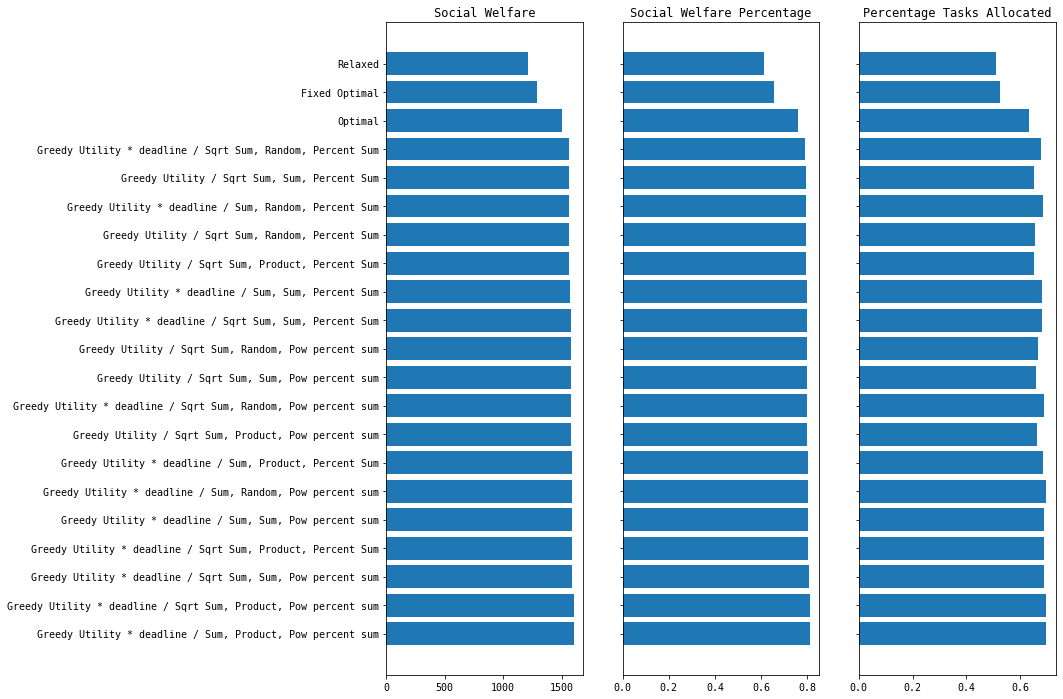

In [5]:
system_fig, (ax_social_welfare, ax_social_welfare_percent, ax_percentage_tasks_allocated) = plt.subplots(1, 3, figsize=(12,12))
ax_social_welfare.barh(algorithm_df['name'], algorithm_df['social welfare'])
ax_social_welfare.set_title('Social Welfare')

ax_social_welfare_percent.barh(algorithm_df['name'], algorithm_df['social welfare percent'])
plt.setp(ax_social_welfare_percent.get_yticklabels(), visible=False)
ax_social_welfare_percent.set_title('Social Welfare Percentage')

ax_percentage_tasks_allocated.barh(algorithm_df['name'], algorithm_df['percentage tasks allocated'])
plt.setp(ax_percentage_tasks_allocated.get_yticklabels(), visible=False)
ax_percentage_tasks_allocated.set_title('Percentage Tasks Allocated')

Text(0.5, 1.0, 'Num Tasks Allocated')

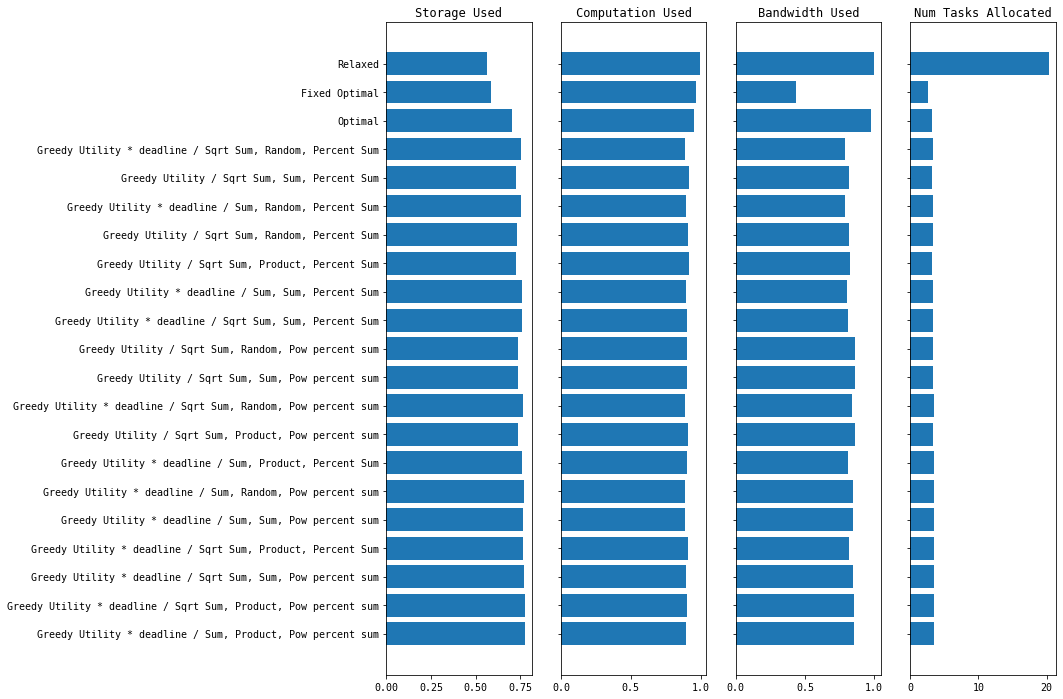

In [6]:
server_fig, (ax_storage_used, ax_computation_used, 
             ax_bandwidth_used, ax_num_tasks_allocated_used) = plt.subplots(1, 4, figsize=(12,12))

ax_storage_used.barh(algorithm_df['name'], algorithm_df['storage used'])
ax_storage_used.set_title('Storage Used')

ax_computation_used.barh(algorithm_df['name'], algorithm_df['computation used'])
plt.setp(ax_computation_used.get_yticklabels(), visible=False)
ax_computation_used.set_title('Computation Used')

ax_bandwidth_used.barh(algorithm_df['name'], algorithm_df['bandwidth used'])
plt.setp(ax_bandwidth_used.get_yticklabels(), visible=False)
ax_bandwidth_used.set_title('Bandwidth Used')

ax_num_tasks_allocated_used.barh(algorithm_df['name'], algorithm_df['num tasks allocated'])
plt.setp(ax_num_tasks_allocated_used.get_yticklabels(), visible=False)
ax_num_tasks_allocated_used.set_title('Num Tasks Allocated')

## Percentage difference in algorithm results and optimal solutions

In [7]:
algorithm_difference_results = []
optimal_algorithm_results = algorithm_results['Optimal']
fixed_optimal_algorithm_results = algorithm_results['Fixed Optimal']

def difference(results_1, results_2):
    sw, swp, pta = [], [], []
    for r1, r2 in zip(results_1, results_2):
        sw.append(r1['social welfare'] / r2['social welfare'])
        swp.append(r1['social welfare percent'] / r2['social welfare percent'])
        pta.append(r1['percentage tasks allocated'] / r2['percentage tasks allocated'])
    return np.mean(sw), np.mean(swp), np.mean(pta), sw

for algorithm, results in algorithm_results.items():
    algorithm_difference_results.append([
        algorithm, 
        *difference(results, optimal_algorithm_results),
        *difference(results, fixed_optimal_algorithm_results)
    ])

algo_diff_df = pd.DataFrame(algorithm_difference_results, columns=[
    'name', 'optimal sw diff', 'optimal swp diff', 
    'optimal pta diff', 'optimal sw diff list',
    'fixed optimal sw diff', 'fixed optimal swp diff', 
    'fixed optimal pta diff', 'fixed optimal sw diff list'])
algo_diff_df = algo_diff_df.sort_values(by='optimal sw diff', ascending=False)

Text(0.5, 1.0, 'Fixed Optimal PTA Difference')

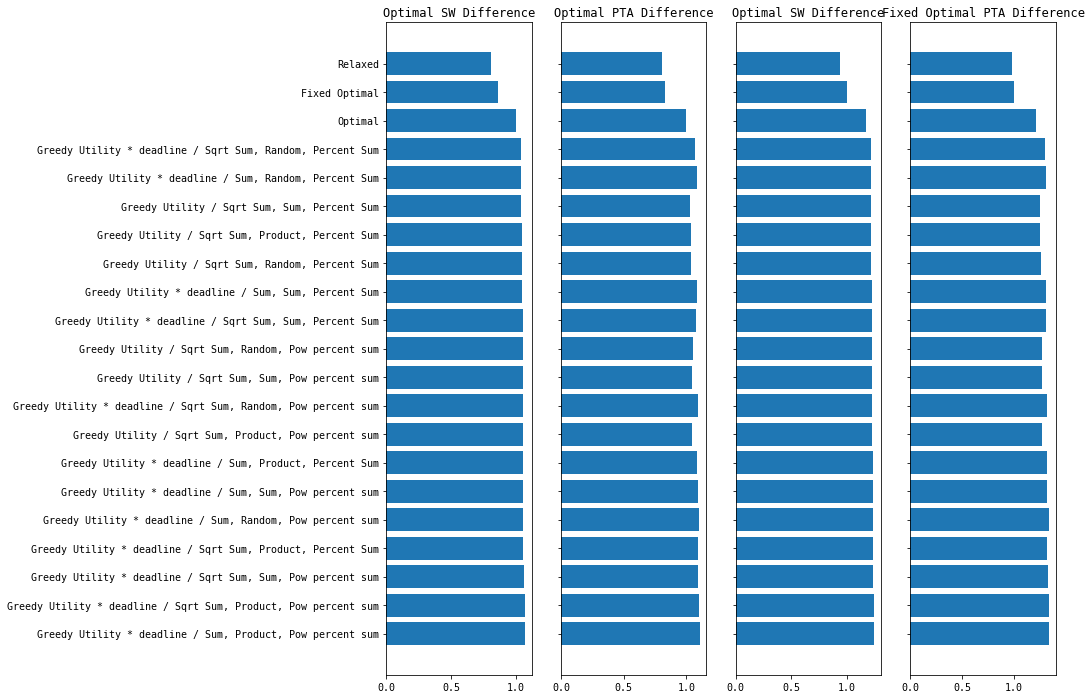

In [8]:
diff_fig, (ax_optimal_sw_diff, ax_optimal_pta_diff, ax_fixed_optimal_sw_diff, 
             ax_fixed_optimal_pta_diff) = plt.subplots(1, 4, figsize=(12,12))
ax_optimal_sw_diff.barh(algo_diff_df['name'], algo_diff_df['optimal sw diff'])
ax_optimal_sw_diff.set_title('Optimal SW Difference')

ax_optimal_pta_diff.barh(algo_diff_df['name'], algo_diff_df['optimal pta diff'])
plt.setp(ax_optimal_pta_diff.get_yticklabels(), visible=False)
ax_optimal_pta_diff.set_title('Optimal PTA Difference')

ax_fixed_optimal_sw_diff.barh(algo_diff_df['name'], algo_diff_df['fixed optimal sw diff'])
plt.setp(ax_fixed_optimal_sw_diff.get_yticklabels(), visible=False)
ax_fixed_optimal_sw_diff.set_title('Optimal SW Difference')

ax_fixed_optimal_pta_diff.barh(algo_diff_df['name'], algo_diff_df['fixed optimal pta diff'])
plt.setp(ax_fixed_optimal_pta_diff.get_yticklabels(), visible=False)
ax_fixed_optimal_pta_diff.set_title('Fixed Optimal PTA Difference')

Text(0.5, 1.0, 'Fixed optimal SW diff points')

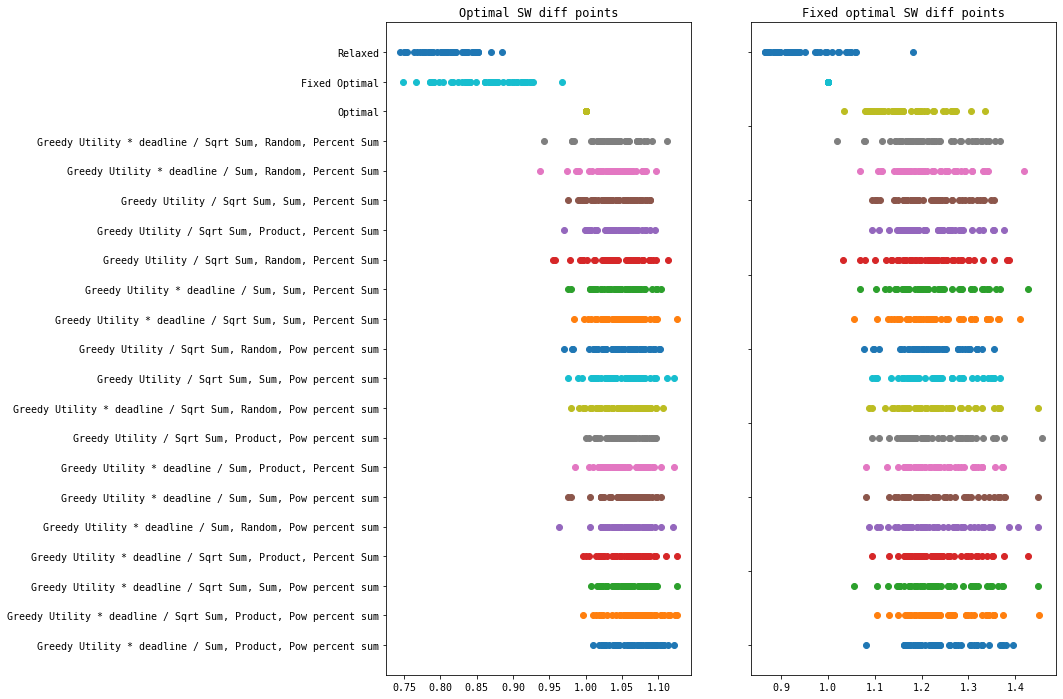

In [9]:
points_fig, (ax_optimal_sw_points, fixed_optimal_sw_points) = plt.subplots(1, 2, figsize=(12,12))
for pos, (optimal_list, fixed_list) in enumerate(algo_diff_df[['optimal sw diff list', 'fixed optimal sw diff list']].values):
    ax_optimal_sw_points.scatter(optimal_list, np.ones(len(optimal_list)) * pos)
    fixed_optimal_sw_points.scatter(fixed_list, np.ones(len(fixed_list)) * pos)

ax_optimal_sw_points.set_yticks(np.arange(len(algo_diff_df['name'])))
ax_optimal_sw_points.set_yticklabels(algo_diff_df['name'], minor=False)
ax_optimal_sw_points.set_title('Optimal SW diff points')
plt.setp(fixed_optimal_sw_points.get_yticklabels(), visible=False)
fixed_optimal_sw_points.set_title('Fixed optimal SW diff points')

## Overall results

Text(0.5, 1.0, 'Greedy Algorithms')

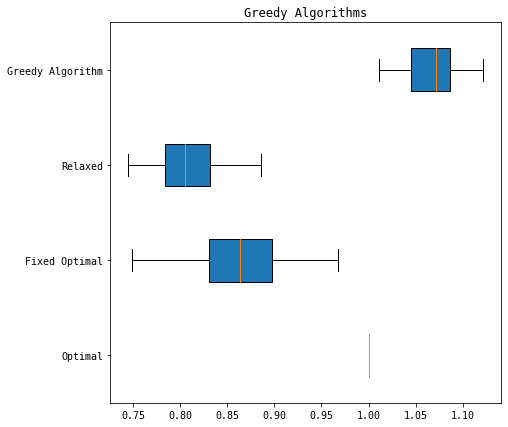

In [19]:
greedy_algo = 'Greedy Utility * deadline / Sum, Product, Pow percent sum'
data = [
    algo_diff_df[algo_diff_df['name'] == 'Optimal']['optimal sw diff list'].item(),
    algo_diff_df[algo_diff_df['name'] == 'Fixed Optimal']['optimal sw diff list'].item(),
    algo_diff_df[algo_diff_df['name'] == 'Relaxed']['optimal sw diff list'].item(),
    algo_diff_df[algo_diff_df['name'] == greedy_algo]['optimal sw diff list'].item()
]

fig, ax_boxplot = plt.subplots(figsize=(7, 7))
ax_boxplot.boxplot(data, vert=False, patch_artist=True)
ax_boxplot.set_yticklabels(['Optimal', 'Fixed Optimal', 'Relaxed', 'Greedy Algorithm'])
ax_boxplot.set_title('Greedy Algorithms')